In [9]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import urllib.request

In [11]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/OFALOFAL/tensorFlow_MyStudySheets/main/TfCommon.py", "TfCommon.py")
import TfCommon

In [3]:
X_train_df = pd.read_csv("X_train.csv")
X_test_df = pd.read_csv("X_test.csv")

y_train_df = pd.read_csv("y_train.csv")
y_test_df = pd.read_csv("y_test.csv")

X_train_df.head()

,Unnamed: 0,valence,energy,acousticness
0,7093,0.646,0.557,0.04290
1,10674,0.480,0.698,0.18000
2,17861,0.446,0.209,0.76500
3,599,0.963,0.729,0.00211
4,16409,0.633,0.686,0.17300


In [4]:
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(np.array(y_train_df['mood']).reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(np.array(y_test_df['mood']).reshape(-1, 1))

train_labels_one_hot[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

We will process acousticness separately as it's less important variable

In [5]:
train_data = tf.data.Dataset.from_tensor_slices((
  X_train_df[['valence', 'energy']],
  X_train_df[['acousticness']]
))

train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_dataset = tf.data.Dataset.zip((train_data, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 12), dtype=tf.float64, name=None))>

In [6]:
test_data = tf.data.Dataset.from_tensor_slices((
  X_test_df[['valence', 'energy']],
  X_test_df[['acousticness']]
))

test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_dataset = tf.data.Dataset.zip((test_data, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 12), dtype=tf.float64, name=None))>

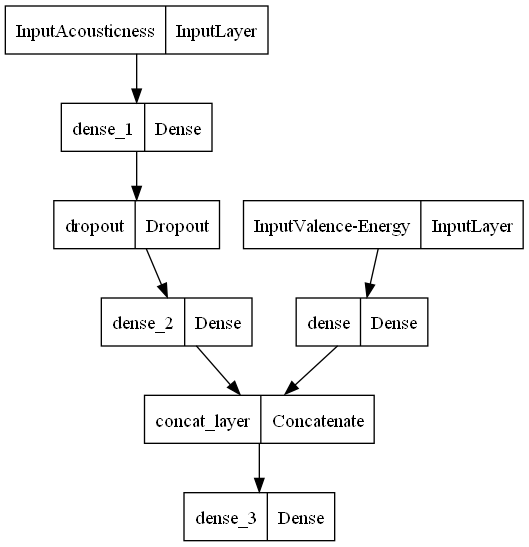

In [7]:
metrics = ['accuracy']

valence_energy_input = tf.keras.layers.Input(shape=(2, ), dtype='float64', name='InputValence-Energy')
valence_energy_output = tf.keras.layers.Dense(64, activation="relu")(valence_energy_input)

valence_energy_model = tf.keras.Model(
    valence_energy_input,
    valence_energy_output,
    name='valence_energy'
)

# using dropout layer to make variable less important
acousticness_input = tf.keras.layers.Input(shape=(1, ), dtype='float64', name='InputAcousticness')
x = tf.keras.layers.Dense(32, activation="relu")(acousticness_input)
x = tf.keras.layers.Dropout(0.1)(x)
acousticness_output = tf.keras.layers.Dense(32, activation="relu")(x)

acousticness_model = tf.keras.Model(
    acousticness_input,
    acousticness_output,
    name='acousticness'
)

concat_layer = tf.keras.layers.Concatenate(name="concat_layer")([
    valence_energy_model.output,
    acousticness_model.output
])

mood_count = 12
output = tf.keras.layers.Dense(mood_count, activation="softmax")(concat_layer)

model = tf.keras.Model(
    inputs=[
        valence_energy_input,
        acousticness_input
    ],
    outputs=output
)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=metrics
)

tf.keras.utils.plot_model(model)

In [8]:
hist = model.fit(
    train_dataset,
    epochs=500,
    verbose=0,
)

In [12]:
SCORE_TO_BEAT = 100/mood_count
SCORE_TO_BEAT

8.333333333333334

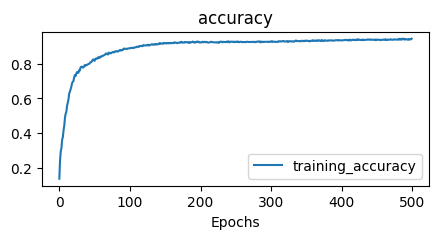

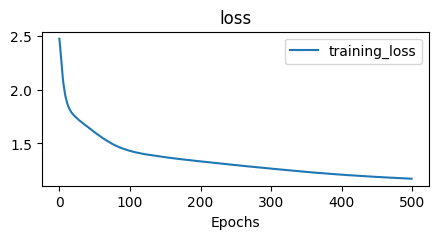

In [13]:
TfCommon.plot_hist_curves([hist], metrics=metrics, val_data=False)

In [14]:
model_pred_probs = model.predict(test_dataset)
model_preds = tf.argmax(model_pred_probs, axis=1)

14/14 [==============================] - 0s 614us/step


In [15]:
label_encoder = LabelEncoder()

results = TfCommon.calculate_results(
    y_true=label_encoder.fit_transform(y_test_df['mood']),
    y_pred=model_preds
)
results

{'accuracy': 91.6267942583732,
 'precision': 0.9221656408787443,
 'recall': 0.916267942583732,
 'f1': 0.9168461644763011}

In [17]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
